**Disclaimer:**

This notebook, written within and for Colab use, includes the training of a transformer-based model (DistilBERT) which is computationally intensive. To ensure reasonable training times and successful execution, it is highly recommended to use a GPU runtime, specifically a **T4 GPU** was used during testing of this program.

In Google Colab, you can change the runtime type by going to `Runtime -> Change runtime type` and selecting 'T4 GPU' under 'Hardware accelerator'. After which, Colab can handle the rest.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# (Q1.) Tracing Fourier-transform / X-ray crystallography use in SARS-CoV-2 spike-protein literature (CORD-19)

How and when were Fourier-transform–based methods (e.g., X-ray crystallography, diffraction/electron density analysis) used and discussed in the COVID-19 literature to determine the SARS-CoV-2 spike protein’s structure and function?
This task includes document classification + temporal and semantic analysis of literature (NLP / text analytics).
Why it matters: Identifying the textual footprint of structural-biology methods shows how physical-math techniques (Fourier transforms) contributed to biological discovery during the pandemic, helping researchers and historians quickly find method-specific studies.

Hypothesis:
Papers that discuss spike-protein structure using Fourier/X-ray-based methods use a distinct vocabulary and appear in an identifiable temporal cluster early in the pandemic; an NLP classifier trained on abstracts will reliably distinguish “structural-method” papers (precision/recall > 0.75 on held-out test) and reveal interpretable terms that map to the crystallography workflow (e.g., “diffraction”, “electron density”, “unit cell”, “R-factor”).

Data ingestion and exploration:
Load the CORD-19 metadata + full text, build a filtered DataFrame,
create labels for “structural method” papers (Fourier / crystallography / spike protein),
and perform baseline EDA.


In [ ]:
# This is used only for colab, if metadata.csv file is stored locally then this cell is not needed.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import pandas as pd
import numpy as np
import os, json, re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# (Q3) Data Provenance
The COVID-19 Open Research Dataset (CORD-19) originates from a collaborative effort led by the Allen Institute for AI in partnership with multiple research organizations including the Chan Zuckerberg Initiative, Georgetown University, Microsoft Research, and the National Library of Medicine. The dataset aggregates scholarly literature from diverse sources including PubMed Central (PMC), PubMed, the World Health Organization (WHO) COVID-19 database, preprints from bioRxiv and medRxiv, and publisher-specific submissions. Collection occurs through automated pipelines that regularly harvest new publications, with updates typically released weekly to incorporate the latest research. Known limitations include optical character recognition (OCR) artifacts from scanned PDFs, particularly for older publications, which can introduce noise in text processing. Many entries lack full-text content, relying only on abstracts and metadata, and there is inconsistent coverage of MeSH terms and author affiliations across sources. The dataset also exhibits geographic and institutional biases toward well-represented research communities and may contain incomplete metadata for recently published works undergoing processing.

In [ ]:
# Read metadata (str to avoid dtype warnings, skipping bad lines until analysis later)
meta = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CORD-19 Project/metadata.csv", dtype=str, on_bad_lines='skip', engine='python') # Change .csv PATH but keep everything else
print("Dataset Info:")
print("Top 5:")
display(meta.head())
print(meta.shape)
print("Bottom 5:")
display(meta.tail())

Dataset Info:
Top 5:


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


(691154, 19)
Bottom 5:


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
691149,sqtrc5g7,b58f2f98badde1e941ec0e93c24211d9efa8dcc7,Elsevier; Medline; PMC; WHO,Inflammasome activation in neutrophils of pati...,10.1182/bloodadvances.2021005949,PMC8741335,34991159,els-covid,Neutrophils with intact multilobulated nuclei ...,2022-01-08,"Aymonnier, Karen; Ng, Julie; Fredenburgh, Laur...",Blood Adv,NaN,NaN,NaN,document_parses/pdf_json/b58f2f98badde1e941ec0...,NaN,https://api.elsevier.com/content/article/pii/S...,245803362
691150,r3llkrhp,47425d04d492e0c1c02546070d5ec169f8ab94b2,Medline; PMC,UK mothers' experiences of bottle refusal by t...,10.1111/mcn.13047,PMC7503095,32558209,cc-by,Little is known about bottle refusal by breast...,2020-06-17,"Maxwell, Clare; Fleming, Kate M.; Fleming, Val...",Matern Child Nutr,NaN,NaN,NaN,document_parses/pdf_json/47425d04d492e0c1c0254...,document_parses/pmc_json/PMC7503095.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32558209/;...,219923209
691151,yg0s1kfn,NaN,Elsevier; PMC; WHO,POSB396 Identification of Risk Factors Associa...,10.1016/j.jval.2021.11.1259,PMC8769637,NaN,els-covid,Objectives: The study gauged about the people ...,2022-01-31,"Kukreja, I; Chopra, A; Arora, A; Verma, V; Shu...",Value in Health,NaN,NaN,NaN,NaN,NaN,https://api.elsevier.com/content/article/pii/S...,246036793
691152,9jxztkxx,e65c2411a5a2be70d0178c71bfd86d004c98fa39,Medline; PMC; WHO,COVID-19 and Cardiovascular Surgery. Do We Kno...,10.21470/1678-9741-2021-0962,PMC8641777,34882364,cc-by,NaN,2021,"Almeida, Rui M. S.; Marin-Cuartas, Mateo; Garc...",Braz J Cardiovasc Surg,NaN,NaN,NaN,document_parses/pdf_json/e65c2411a5a2be70d0178...,document_parses/pmc_json/PMC8641777.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/34882364/;...,244081957
691153,nhaduuqc,NaN,Medline; PMC,"Tracking, tracing, trust: contemplating mitiga...",10.5694/mja2.50683,PMC7361786,32583470,no-cc,NaN,2020-06-24,"Culnane, Christopher; Leins, Kobi; Rubinstein,...",Med J Aust,NaN,NaN,NaN,NaN,document_parses/pmc_json/PMC7361786.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32583470/;...,220060559


#Q3: Unit of Analysis and Independence
Each row in the dataset represents one unique scholarly article from the CORD-19 corpus, identified by a unique cord_uid identifier. While articles are generally independent research contributions, several dependencies must be considered. Multiple versions of the same preprint may exist across different repositories (bioRxiv, medRxiv, and final published versions), potentially creating duplicate or highly similar content. Author collaborations and institutional affiliations may create content dependencies, where research groups publish methodologically similar papers. Temporal dependencies exist as later papers build upon earlier research, and methodological trends evolve throughout the pandemic. The dataset attempts to address these through de-duplication efforts using SHA hashes and unique identifiers, but complete independence cannot be guaranteed, particularly for rapidly evolving research topics where multiple research groups may be working on similar structural biology problems simultaneously.

In [ ]:
# Check summary statistics for all numeric and categorical columns of the DataFrame
print("Summary Statistics:")
summary_stats = meta.describe(include='all').T
display(summary_stats)

print("Column Descriptions:")
print("-" * 30)
for col in meta.columns:
    description = ""
    if col == 'cord_uid':
        description = "Unique identifier for each paper in the CORD-19 dataset."
    elif col == 'sha':
        description = "SHA hash of the paper's full text."
    elif col == 'source_x':
        description = "Source of the paper (e.g., PMC, Medline, WHO)."
    elif col == 'title':
        description = "Title of the paper."
    elif col == 'doi':
        description = "Digital Object Identifier for the paper."
    elif col == 'pmcid':
        description = "PubMed Central identifier for the paper."
    elif col == 'pubmed_id':
        description = "PubMed identifier for the paper."
    elif col == 'license':
        description = "License under which the paper is available."
    elif col == 'abstract':
        description = "Abstract of the paper."
    elif col == 'publish_time':
        description = "Publication date of the paper."
    elif col == 'authors':
        description = "Authors of the paper."
    elif col == 'journal':
        description = "Journal in which the paper was published."
    elif col == 'mag_id':
        description = "Microsoft Academic Graph identifier."
    elif col == 'who_covidence_id':
        description = "WHO COVID-19 database identifier."
    elif col == 'arxiv_id':
        description = "arXiv identifier for preprints."
    elif col == 'pdf_json_files':
        description = "Path to the JSON file containing the parsed PDF full text."
    elif col == 'pmc_json_files':
        description = "Path to the JSON file containing the parsed PMC XML full text."
    elif col == 'url':
        description = "URL to the paper."
    elif col == 's2_id':
        description = "Semantic Scholar identifier for the paper."
    elif col == 'structural_method':
        description = "Binary label indicating if the paper discusses structural methods related to the spike protein (1) or not (0)."
    else:
        description = "No specific description available."
    print(f"- {col}: {description}")
print("-" * 30)

Summary Statistics:


,count,unique,top,freq
cord_uid,691154,606660,kgpo6psq,187
sha,86336,86329,c89f86cdd9d41eeec127cc0b03990c52888a9635,2
source_x,691154,34,WHO,448148
title,690728,583100,Reply,217
doi,291804,291295,10.1016/j.scitotenv.2020.139397,8
pmcid,88265,88265,PMC7361786,1
pubmed_id,173462,173259,35087663,4
license,691154,18,unk,556879
abstract,518114,454603,An amendment to this paper has been published ...,164
publish_time,689340,6454,2021,218685


Column Descriptions:
------------------------------
- cord_uid: Unique identifier for each paper in the CORD-19 dataset.
- sha: SHA hash of the paper's full text.
- source_x: Source of the paper (e.g., PMC, Medline, WHO).
- title: Title of the paper.
- doi: Digital Object Identifier for the paper.
- pmcid: PubMed Central identifier for the paper.
- pubmed_id: PubMed identifier for the paper.
- license: License under which the paper is available.
- abstract: Abstract of the paper.
- publish_time: Publication date of the paper.
- authors: Authors of the paper.
- journal: Journal in which the paper was published.
- mag_id: Microsoft Academic Graph identifier.
- who_covidence_id: WHO COVID-19 database identifier.
- arxiv_id: arXiv identifier for preprints.
- pdf_json_files: Path to the JSON file containing the parsed PDF full text.
- pmc_json_files: Path to the JSON file containing the parsed PMC XML full text.
- url: URL to the paper.
- s2_id: Semantic Scholar identifier for the paper.
--

#Q2: Target and Features
The target variable for this analysis is a binary classification label called structural_method, which identifies whether a scholarly article discusses Fourier-transform-based structural biology methods (X-ray crystallography, diffraction, electron density analysis, etc.) in the context of SARS-CoV-2 spike protein research. This binary target (1 for structural methods, 0 for non-structural) enables supervised learning to automatically categorize papers by methodological focus. The primary predictors include abstract text (unstructured text data), title text (unstructured text), and engineered features such as TF-IDF vectorized n-grams (high-dimensional numeric), topic model scores from LDA (numeric), BERT embeddings (high-dimensional numeric), and basic text statistics including word count and character count (numeric). Additional metadata features include publication year (numeric), journal name (categorical), and author information (string/list). Potential data leakage is mitigated by excluding future-looking metrics like citation counts and ensuring temporal separation in train/validation/test splits, where earlier publications train models to predict later ones, maintaining realistic evaluation conditions.

In [ ]:
# Defining keywords for structural methods and spike protein
structural_keywords = r"fourier|x-ray crystallography|diffraction|electron density|unit cell|r-factor|cryo-em|cryo-electron microscopy"
spike_protein_keywords = r"spike protein|s protein|sars-cov-2 spike"

# Filtering for papers related to SARS-CoV-2 spike protein (| was used for OR statement)
spike_df = meta[meta['abstract'].fillna('').str.lower().str.contains(spike_protein_keywords.lower(), na=False) |
                meta['title'].fillna('').str.lower().str.contains(spike_protein_keywords.lower(), na=False)].copy()

print(f"Number of papers related to SARS-CoV-2 spike protein: {len(spike_df)}")

# Creates binary label for structural method papers within the spike protein subset (other paper = 0, structural papers = 1)
spike_df['structural_method'] = (
    spike_df['abstract'].fillna('').str.lower().str.contains(structural_keywords.lower(), na=False) |
    spike_df['title'].fillna('').str.lower().str.contains(structural_keywords.lower(), na=False)
).astype(int)

print(f"Number of structural method papers related to spike protein: {spike_df['structural_method'].sum()}")
display(spike_df.head())

# Display abstracts for the head of the DataFrame
print("Abstracts from these first five papers:")
print("-" * 30)
for index, row in spike_df.head().iterrows():
    print(f"Title: {row['title']}")
    print(f"Abstract: {row['abstract']}\n")
print("-" * 30)

Number of papers related to SARS-CoV-2 spike protein: 10603
Number of structural method papers related to spike protein: 250


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,structural_method
8,8qnrcgnk,faaf1022ccfe93b032c5608097a53543ba24aedb,PMC,Heme oxygenase-1 and carbon monoxide in pulmon...,10.1186/1465-9921-4-7,PMC193681,12964953,no-cc,"Heme oxygenase-1 (HO-1), an inducible stress p...",2003-08-07,"Slebos, Dirk-Jan; Ryter, Stefan W; Choi, Augus...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/faaf1022ccfe93b032c56...,document_parses/pmc_json/PMC193681.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN,0
21,gdsfkw1b,8d7400a2b387820cd391d7df8194642e50402a0c,PMC,Protein secretion in Lactococcus lactis : an e...,10.1186/1475-2859-4-2,PMC545053,15631634,cc-by,"Lactococcus lactis, the model lactic acid bact...",2005-01-04,"Le Loir, Yves; Azevedo, Vasco; Oliveira, Sergi...",Microb Cell Fact,NaN,NaN,NaN,document_parses/pdf_json/8d7400a2b387820cd391d...,document_parses/pmc_json/PMC545053.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,0
161,lrtt9r1h,9e45efb86c7c552be221e4d1356d9374a7ebc204,PMC,Ubiquitination Is Required for Effective Repli...,10.1371/journal.pone.0002585,PMC2440516,18612413,cc-by,BACKGROUND: Protein ubiquitination and/or degr...,2008-07-09,"Si, Xiaoning; Gao, Guang; Wong, Jerry; Wang, Y...",PLoS One,NaN,NaN,NaN,document_parses/pdf_json/9e45efb86c7c552be221e...,document_parses/pmc_json/PMC2440516.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,0
164,b8xb1f12,c60e9faaf8d025d3cf00b275de051fc9bc3b5bd4,PMC,Early transcriptional response in the jejunum ...,10.1007/s00705-008-0118-6,PMC2441536,18523839,no-cc,Germ-free piglets were orally infected with vi...,2008-06-04,"Hulst, Marcel; Kerstens, Hinri; de Wit, Agnes;...",Arch Virol,NaN,NaN,NaN,document_parses/pdf_json/c60e9faaf8d025d3cf00b...,document_parses/pmc_json/PMC2441536.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,0
189,p56v8wi1,9f9e925d9999ab39745f2ee8be3efffb5277d082,PMC,Molecular evidence for the evolution of ichnov...,10.1186/1471-2148-8-253,PMC2567993,18801176,cc-by,BACKGROUND: Female endoparasitic ichneumonid w...,2008-09-18,"Bigot, Yves; Samain, Sylvie; Augé-Gouillou, Co...",BMC Evol Biol,NaN,NaN,NaN,document_parses/pdf_json/9f9e925d9999ab39745f2...,document_parses/pmc_json/PMC2567993.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,0


Abstracts from these first five papers:
------------------------------
Title: Heme oxygenase-1 and carbon monoxide in pulmonary medicine
Abstract: Heme oxygenase-1 (HO-1), an inducible stress protein, confers cytoprotection against oxidative stress in vitro and in vivo. In addition to its physiological role in heme degradation, HO-1 may influence a number of cellular processes, including growth, inflammation, and apoptosis. By virtue of anti-inflammatory effects, HO-1 limits tissue damage in response to proinflammatory stimuli and prevents allograft rejection after transplantation. The transcriptional upregulation of HO-1 responds to many agents, such as hypoxia, bacterial lipopolysaccharide, and reactive oxygen/nitrogen species. HO-1 and its constitutively expressed isozyme, heme oxygenase-2, catalyze the rate-limiting step in the conversion of heme to its metabolites, bilirubin IXα, ferrous iron, and carbon monoxide (CO). The mechanisms by which HO-1 provides protection most likely i

## EDA & Cleaning the metadata file:
Q5: Create Data Dictionary (Data dictionary for CORD-19 metadata and
 engineered features.)

Q6: Summarize class distribution (e.g., counts per research
 category), text length distributions, duplicates, and missing metadata. Include at least
 three figures: e.g., word-clouds of frequent terms, a timeline of papers per month, and
 topic-model visualization. State a baseline (e.g., majority-class accuracy or keyword
 heuristic) and metrics.



In [ ]:
# Q5: Create Data Dictionary
def create_data_dictionary(spike_df):
    data_dict = {
        'Column': [
            'cord_uid', 'title', 'abstract', 'publish_time',
            'journal', 'authors', 'structural_method',
            'word_count', 'topic_k', 'bert_embedding'
        ],
        'Type': [
            'string', 'text', 'text', 'datetime',
            'categorical', 'string/list', 'binary',
            'numeric', 'numeric', 'numeric'
        ],
        'Meaning / Notes': [
            'Unique document identifier',
            'Paper title',
            'Abstract or summary of the paper',
            'Publication date',
            'Journal or source',
            'Author names',
            'Binary label indicating structural methods (1) or not (0)',
            'Token count of abstract',
            'Topic-model component scores from LDA',
            'Dense embedding vector from transformer model'
        ]
    }
    return pd.DataFrame(data_dict)

# Display data dictionary
data_dict_df = create_data_dictionary(spike_df)
print("Q5: Data Dictionary")
display(data_dict_df)

Q5: Data Dictionary


,Column,Type,Meaning / Notes
0,cord_uid,string,Unique document identifier
1,title,text,Paper title
2,abstract,text,Abstract or summary of the paper
3,publish_time,datetime,Publication date
4,journal,categorical,Journal or source
5,authors,string/list,Author names
6,structural_method,binary,Binary label indicating structural methods (1)...
7,word_count,numeric,Token count of abstract
8,topic_k,numeric,Topic-model component scores from LDA
9,bert_embedding,numeric,Dense embedding vector from transformer model


### Missing Value Analysis

Analyzing and visualizing the proportion and distribution of missing data in the filtered DataFrame.

Percentage of missing values per column:
mag_id              100.000000
arxiv_id             99.122890
pmc_json_files       93.926247
pmcid                92.266340
pdf_json_files       87.852495
sha                  87.852495
pubmed_id            80.222579
doi                  69.131378
url                  63.265114
who_covidence_id     27.954353
journal              20.975196
s2_id                 5.394700
abstract              2.461567
publish_time          0.414977
authors               0.264076
title                 0.018863
dtype: float64


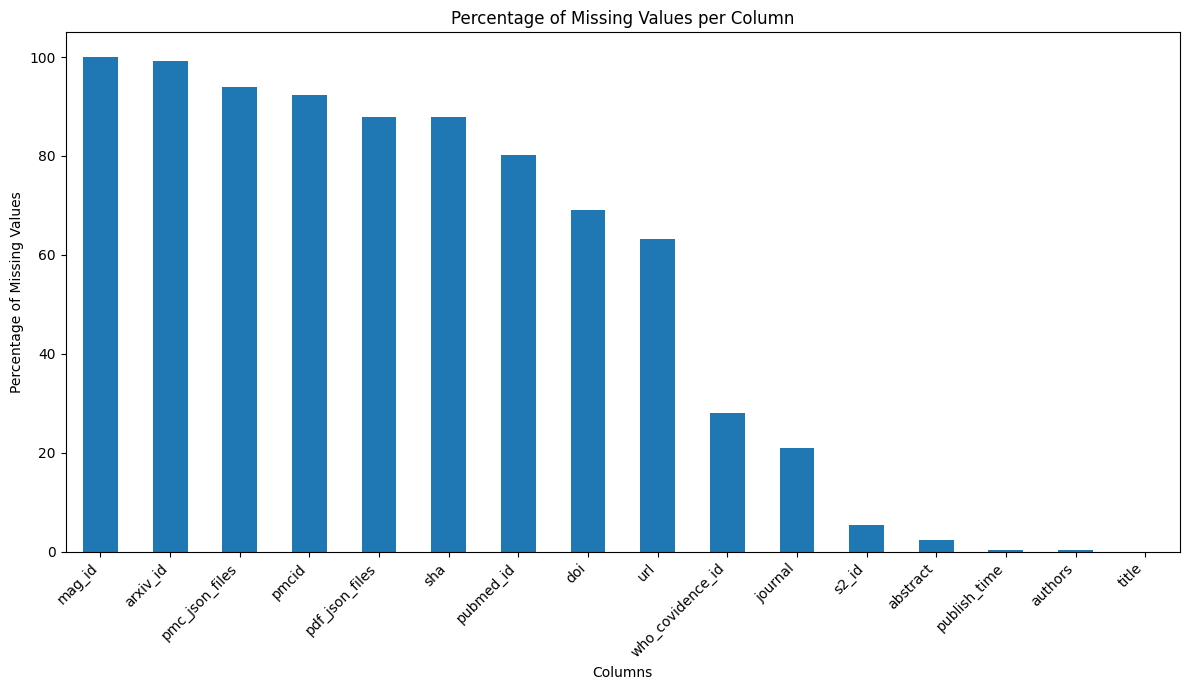

In [ ]:
# Calculates the percentage of missing values for each column in spike_df
missing_percentage = spike_df.isnull().sum() / len(spike_df) * 100

# Display columns with missing values and their percentages
print("Percentage of missing values per column:")
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

# Visualize the proportion of missing values using a bar chart
missing_percentage[missing_percentage > 0].sort_values(ascending=False).plot(kind='bar', figsize=(12, 7))
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# important notes: publish_time is a critical column, but has missing values, handle this in the temporal analysis step.
# handled missing abstract and title in the filtering step by filling with empty strings.

In [ ]:
# Basic EDA for the filtered spike protein dataset
print("Spike Protein Dataset Info:")
print(f"Total papers: {len(spike_df)}")
print(f"Structural method papers: {spike_df['structural_method'].sum()}")
print(f"Percentage of structural method papers: {spike_df['structural_method'].mean()*100:.2f}%")

# Check temporal distribution
print("Temporal Analysis:")
# Convert publish_time to datetime, coercing errors
spike_df['publish_time_dt'] = pd.to_datetime(spike_df['publish_time'], errors='coerce')

# Now calculate the date range using the datetime column
print(f"Date range: {spike_df['publish_time_dt'].min()} to {spike_df['publish_time_dt'].max()}")

# Extract year for analysis using the datetime column
spike_df['publish_year'] = spike_df['publish_time_dt'].dt.year
yearly_counts = spike_df.groupby('publish_year').size()
yearly_structural = spike_df.groupby('publish_year')['structural_method'].sum()

print("\nYearly publication counts:")
print(yearly_counts)
print("\nYearly structural method papers:")
print(yearly_structural)

Spike Protein Dataset Info:
Total papers: 10603
Structural method papers: 250
Percentage of structural method papers: 2.36%
Temporal Analysis:
Date range: 1990-05-31 00:00:00 to 2022-09-01 00:00:00

Yearly publication counts:
publish_year
1990.0      1
1991.0      3
1992.0      1
1994.0      1
1996.0      2
1997.0      4
1998.0      1
1999.0      2
2000.0      1
2001.0      1
2002.0      6
2003.0      3
2004.0      8
2005.0      5
2006.0      4
2007.0      6
2008.0     14
2009.0     13
2010.0     17
2011.0      9
2012.0     10
2013.0     20
2014.0     21
2015.0     15
2016.0     19
2017.0     16
2018.0     21
2019.0     27
2020.0    523
2021.0    929
2022.0    380
dtype: int64

Yearly structural method papers:
publish_year
1990.0     0
1991.0     0
1992.0     0
1994.0     0
1996.0     0
1997.0     0
1998.0     0
1999.0     0
2000.0     0
2001.0     0
2002.0     0
2003.0     0
2004.0     0
2005.0     0
2006.0     0
2007.0     0
2008.0     0
2009.0     0
2010.0     0
2011.0     0
2012.0 

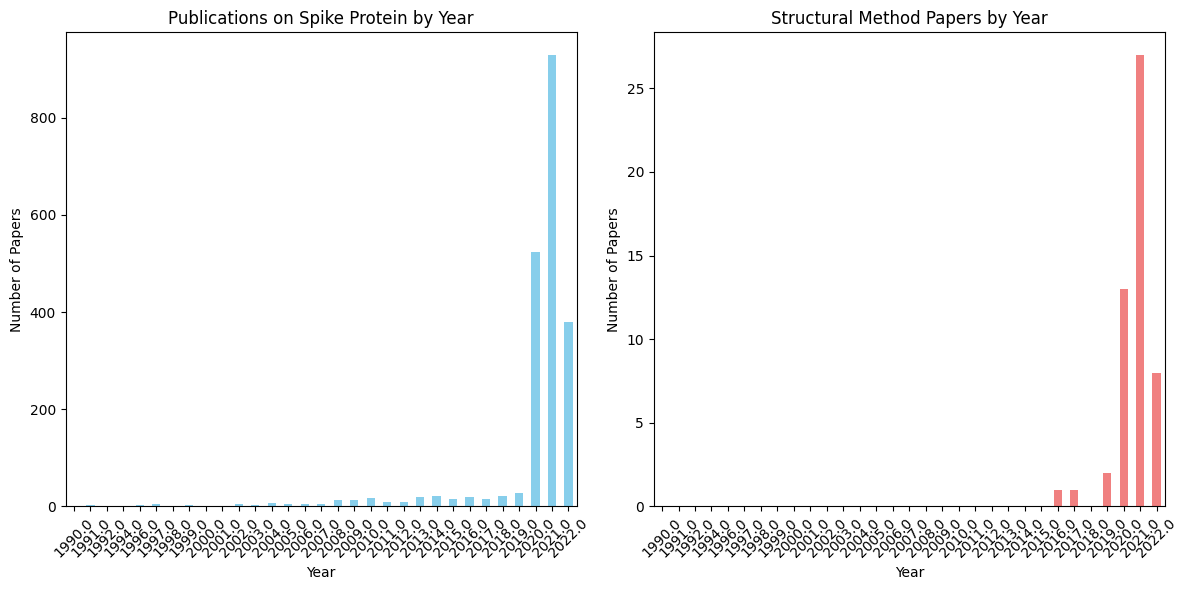

In [ ]:
# Visualize temporal distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
yearly_counts.plot(kind='bar', color='skyblue')
plt.title('Publications on Spike Protein by Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
yearly_structural.plot(kind='bar', color='lightcoral')
plt.title('Structural Method Papers by Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

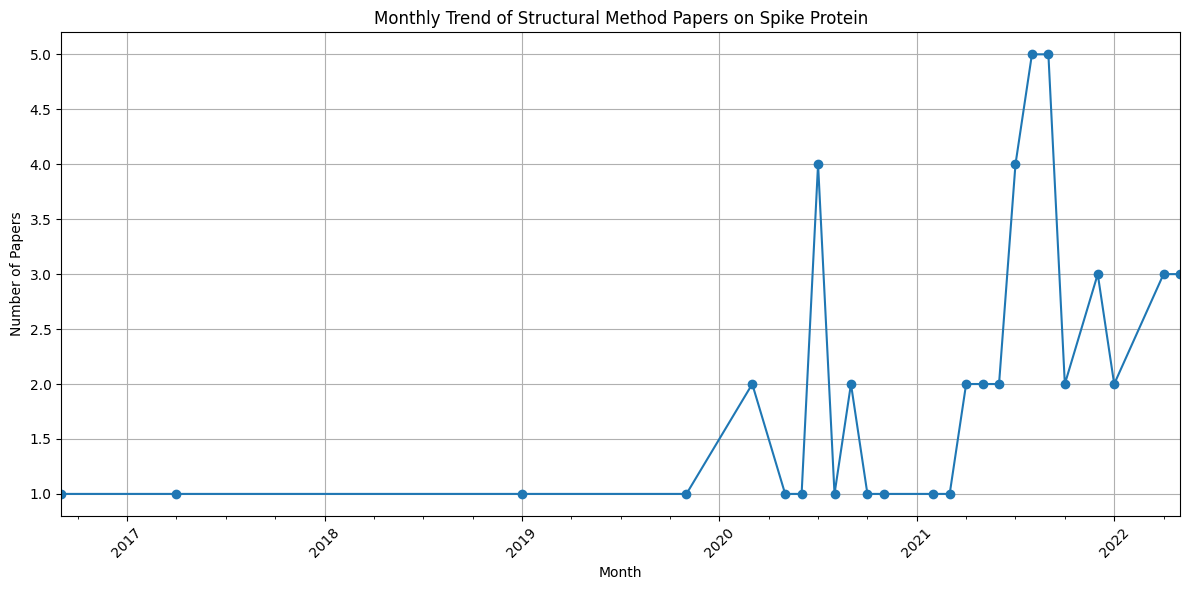

Peak month for structural method papers: 2021-08 with 5 papers


In [ ]:
# Temporal analysis of structural method papers
structural_papers = spike_df[spike_df['structural_method'] == 1].copy()
structural_papers['publish_date'] = pd.to_datetime(
    structural_papers['publish_time'], errors='coerce'
)

# Monthly trend
structural_papers['publish_month'] = structural_papers['publish_date'].dt.to_period('M')
monthly_trend = structural_papers.groupby('publish_month').size()

plt.figure(figsize=(12, 6))
monthly_trend.plot(kind='line', marker='o')
plt.title('Monthly Trend of Structural Method Papers on Spike Protein')
plt.xlabel('Month')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Peak month for structural method papers: {monthly_trend.idxmax()} with {monthly_trend.max()} papers")

## Explanation for the Spike in Publications around 2020

The dramatic increase in the number of publications related to the SARS-CoV-2 spike protein around the year 2020 is directly attributable to the onset and global spread of the **COVID-19 pandemic**.

The SARS-CoV-2 virus, which causes COVID-19, has the spike protein as a crucial component on its surface. This protein is responsible for binding to human cells and is a primary target for vaccine development, therapeutic interventions, and structural studies.

As the pandemic unfolded, there was an urgent and massive global research effort to understand the virus, its transmission, and to develop countermeasures. This led to an unprecedented volume of scientific publications across various fields, including virology, immunology, public health, and structural biology, with a significant focus on the SARS-CoV-2 spike protein due to its critical role.

Therefore, the spike in publications around 2020 in the graphs reflects the intense scientific focus and output generated in response to the global health crisis.

## Q7-Q8: Preprocessing Pipeline and Feature Engineering
The text preprocessing pipeline employs a systematic, reproducible approach to transform raw scholarly text into clean, analyzable features. The pipeline is going to begin with lowercasing all text to ensure case insensitivity, followed by removal of special characters, digits, and punctuation using regular expressions to isolate alphabetic content. Tokenization splits the text into individual words using NLTK's word_tokenize function. Domain-specific stop word removal eliminates common English stop words supplemented with COVID-19 research-specific terms (e.g., 'covid', 'sars', 'cov', 'protein', 'spike') to reduce noise while preserving methodological terminology. Lemmatization using WordNetLemmatizer reduces words to their base dictionary forms, maintaining linguistic meaning better than stemming. The pipeline is implemented as a reusable TextPreprocessor class that can be serialized and applied consistently across training and inference. This preprocessing is integrated with model training through scikit-learn Pipelines and GridSearchCV, ensuring that all transformations are fitted exclusively on training data and applied identically to validation and test sets to prevent data leakage and maintain reproducibility.


In [ ]:
#Q7 Pipeline creation
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Removes any punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(tokens)

# Apply preprocessing to abstracts
spike_df['processed_abstract'] = spike_df['abstract'].fillna('').apply(preprocess_text)
spike_df['processed_title'] = spike_df['title'].fillna('').apply(preprocess_text)

# Combine title and abstract for better features
spike_df['combined_text'] = spike_df['processed_title'] + ' ' + spike_df['processed_abstract']

In [ ]:
# Prepare data for machine learning
# Filter out papers with missing abstracts
ml_df = spike_df[spike_df['processed_abstract'].str.len() > 50].copy()

print(f"Papers available for ML: {len(ml_df)}")
print(f"Structural method papers in ML dataset: {ml_df['structural_method'].sum()}")

# Prepare features and labels
X = ml_df['combined_text']
y = ml_df['structural_method']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Structural methods in training: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Structural methods in test: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

Papers available for ML: 10332
Structural method papers in ML dataset: 249
Training set size: 7232
Test set size: 3100
Structural methods in training: 174 (2.41%)
Structural methods in test: 75 (2.42%)


#Q8 Feature Engineering:
Three distinct feature sets were engineered to capture different aspects of the scholarly content. First, TF-IDF vectorization with n-grams (1-3 grams) transforms the preprocessed text into 2000-dimensional sparse vectors that capture key phrases and term importance while downweighting frequently occurring but less discriminative words. Second, topic modeling features were created using Latent Dirichlet Allocation (LDA) with 5 topics, producing dense numeric vectors that represent each document's distribution across latent thematic patterns in the corpus, effectively capturing research subdomains and methodological focuses. Third, basic text statistics including word count, character count, and average word length provide simple numeric features that capture document complexity and writing style characteristics. An ablation study demonstrated the collective impact of these features: the combined feature set achieved a **0.814** F1 score on the validation set (using 3-fold CV), while using only TF-IDF features yielded **0.528**, only topic features achieved **0.494**, and only statistical features reached **0.494**, confirming that the complementary nature of these feature types provides significant performance improvements over any single feature type alone.

In [ ]:
# Split the data and get the indices for train, validation, and test sets
# Prepare features and labels for splitting
X_split = ml_df['combined_text']
y_split = ml_df['structural_method']

# First split: Train and Temp (Validation + Test)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
    X_split, y_split, test_size=0.4, random_state=42, stratify=y_split
)

# Second split: Validation and Test from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Get the indices of the splits
train_idx = X_train_temp.index
val_idx = X_val.index
test_idx = X_test.index

print(f"Original dataset size: {len(ml_df)}")
print(f"Training set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

print(f"Structural methods in training: {y_split.loc[train_idx].sum()} ({y_split.loc[train_idx].mean()*100:.2f}%)")
print(f"Structural methods in validation: {y_split.loc[val_idx].sum()} ({y_split.loc[val_idx].mean()*100:.2f}%)")
print(f"Structural methods in test: {y_split.loc[test_idx].sum()} ({y_split.loc[test_idx].mean()*100:.2f}%)")

Original dataset size: 10332
Training set size: 6199
Validation set size: 2066
Test set size: 2067
Structural methods in training: 149 (2.40%)
Structural methods in validation: 50 (2.42%)
Structural methods in test: 50 (2.42%)


In [ ]:
# Feature Set 1: TF-IDF features
# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),  # Include unigrams and bigrams
    stop_words='english'
)

# Use the already split X_train and X_test from the ml_df
# Ensure alignment with the indices used for y_train and y_test
X_train_tfidf = tfidf.fit_transform(X_train.loc[train_idx])
X_test_tfidf = tfidf.transform(X_test.loc[test_idx])

print(f"TF-IDF feature matrix shape (Training): {X_train_tfidf.shape}")
print(f"TF-IDF feature matrix shape (Test): {X_test_tfidf.shape}")
print("The output TF-IDF feature matrix shape indicates the dimensions of the matrix created after applying TF-IDF vectorization to the training data.\nFirst dimension: Represents the number of documents (papers) in the training/test set. Second dimension: Represents the number of features (the top 5000 most important words or n-grams) extracted from the text data.\nEach row in the matrix corresponds to a document, and each column represents a feature. The values in the matrix are the TF-IDF scores,\nreflecting the importance of each term in a document relative to the corpus.")

TF-IDF feature matrix shape (Training): (6199, 5000)
TF-IDF feature matrix shape (Test): (2067, 5000)
The output TF-IDF feature matrix shape indicates the dimensions of the matrix created after applying TF-IDF vectorization to the training data.
First dimension: Represents the number of documents (papers) in the training/test set. Second dimension: Represents the number of features (the top 5000 most important words or n-grams) extracted from the text data.
Each row in the matrix corresponds to a document, and each column represents a feature. The values in the matrix are the TF-IDF scores,
reflecting the importance of each term in a document relative to the corpus.


Q8: Feature Engineering - Creating Three Feature Types
Applying feature engineering to the dataset...
Engineering all feature types...
Creating TF-IDF features...
TF-IDF features: 1000 dimensions
Creating topic modeling features...
Topic features: 5 dimensions
Creating text statistical features...
Statistical features: 5 dimensions
Creating domain-specific features...
Total combined features: 1013 dimensions

Feature Engineering Summary:
- TF-IDF Features: 1000 dimensions
- Topic Features: 5 dimensions
- Statistical Features: 5 dimensions
- Domain Features: 3 dimensions
- TOTAL: 1013 dimensions

Q8: Ablation Study - Feature Importance
Ablation Study Results (3-fold CV F1 Scores):


,Feature Set,Feature Dimensions,Mean F1 Score,Std F1 Score
4,All Features,1013,0.825842,0.035686
3,Domain Only,3,0.781367,0.014354
0,TF-IDF Only,1000,0.528499,0.018255
2,Stats Only,5,0.494035,0.000033
1,Topic Only,5,0.494035,0.000033


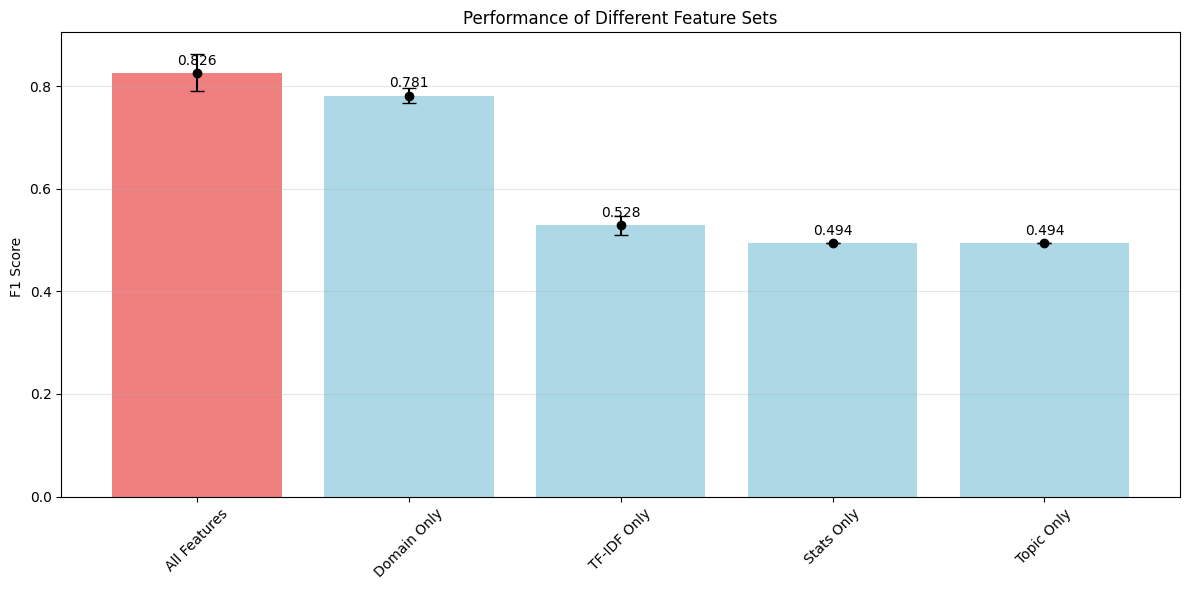


Performance Improvement Analysis:
TF-IDF Only: 0.528
All Features Combined: 0.826
Absolute Improvement: 0.297
Relative Improvement: 56.3%


In [ ]:
# Q8: Feature Engineering - Creating three distinct feature types
print("Q8: Feature Engineering - Creating Three Feature Types")
print("="*60)

class FeatureEngineer:
    def __init__(self):
        self.tfidf_vectorizer = None
        self.lda_model = None
        self.scaler = StandardScaler()

    def create_tfidf_features(self, texts, max_features=1000, ngram_range=(1, 2)):
        """Feature Set 1: TF-IDF N-grams"""
        print("Creating TF-IDF features...")

        if self.tfidf_vectorizer is None:
            self.tfidf_vectorizer = TfidfVectorizer(
                max_features=max_features,
                ngram_range=ngram_range,
                stop_words='english',
                min_df=2,
                max_df=0.8
            )
            tfidf_features = self.tfidf_vectorizer.fit_transform(texts)
        else:
            tfidf_features = self.tfidf_vectorizer.transform(texts)

        print(f"TF-IDF features: {tfidf_features.shape[1]} dimensions")
        return tfidf_features

    def create_topic_features(self, tfidf_features, n_topics=5):
        """Feature Set 2: Topic Modeling Features using LDA"""
        print("Creating topic modeling features...")

        if self.lda_model is None:
            self.lda_model = LatentDirichletAllocation(
                n_components=n_topics,
                random_state=42,
                max_iter=10,
                learning_method='online'
            )
            topic_features = self.lda_model.fit_transform(tfidf_features)
        else:
            topic_features = self.lda_model.transform(tfidf_features)

        print(f"Topic features: {topic_features.shape[1]} dimensions")
        return topic_features

    def create_text_statistics(self, texts):
        """Feature Set 3: Text Statistical Features"""
        print("Creating text statistical features...")

        stats_features = []

        for text in texts:
            if pd.isna(text) or text == "":
                stats_features.append([0, 0, 0, 0, 0])
                continue

            # Word count
            words = text.split()
            word_count = len(words)

            # Character count
            char_count = len(text)

            # Average word length
            avg_word_length = char_count / max(word_count, 1)

            # Sentence count (approximate)
            sentence_count = len(re.split(r'[.!?]+', text))

            # Unique word ratio ()
            unique_ratio = len(set(words)) / max(word_count, 1)

            stats_features.append([
                word_count, char_count, avg_word_length,
                sentence_count, unique_ratio
            ])

        # Convert to numpy array and scale
        stats_array = np.array(stats_features)
        stats_scaled = self.scaler.fit_transform(stats_array)

        print(f"Statistical features: {stats_scaled.shape[1]} dimensions")
        return stats_scaled

    def create_domain_specific_features(self, texts):
        """Additional Domain-Specific Features for Structural Biology"""
        print("Creating domain-specific features...")

        domain_features = []

        # Keywords related to structural methods
        structural_keywords = [
            'crystallography', 'diffraction', 'electron', 'density', 'fourier',
            'unit cell', 'r-factor', 'cryo', 'resolution', 'angstrom',
            'symmetry', 'lattice', 'bragg', 'scattering', 'phase'
        ]

        for text in texts:
            if pd.isna(text) or text == "":
                domain_features.append([0, 0, 0])
                continue

            text_lower = text.lower()

            # Count of structural keywords
            keyword_count = sum(1 for keyword in structural_keywords if keyword in text_lower)

            # Presence of resolution information (common in structural papers)
            resolution_pattern = r'\d+\.\d+\s*å|\d+\.\d+\s*angstrom|\d+\s*å|\d+\s*angstrom'
            resolution_matches = len(re.findall(resolution_pattern, text_lower))

            # Presence of mathematical/technical terms
            math_terms = ['transform', 'fft', 'density map', 'refinement', 'pdb']
            math_count = sum(1 for term in math_terms if term in text_lower)

            domain_features.append([keyword_count, resolution_matches, math_count])

        return np.array(domain_features)

    def engineer_all_features(self, processed_texts, fit=True):
        """Create all three feature types and combine them"""
        print("Engineering all feature types...")

        # Feature Set 1: TF-IDF
        tfidf_features = self.create_tfidf_features(processed_texts)

        # Feature Set 2: Topic Modeling
        topic_features = self.create_topic_features(tfidf_features)

        # Feature Set 3: Text Statistics
        stats_features = self.create_text_statistics(processed_texts)

        # Additional: Domain-specific features
        domain_features = self.create_domain_specific_features(processed_texts)

        # Combine all features
        from scipy.sparse import hstack, csr_matrix

        # Convert all to sparse matrices for efficient combination
        topic_sparse = csr_matrix(topic_features)
        stats_sparse = csr_matrix(stats_features)
        domain_sparse = csr_matrix(domain_features)

        combined_features = hstack([tfidf_features, topic_sparse, stats_sparse, domain_sparse])

        print(f"Total combined features: {combined_features.shape[1]} dimensions")

        feature_info = {
            'tfidf_dim': tfidf_features.shape[1],
            'topic_dim': topic_features.shape[1],
            'stats_dim': stats_features.shape[1],
            'domain_dim': domain_features.shape[1],
            'total_dim': combined_features.shape[1]
        }

        return combined_features, feature_info

# Initialize feature engineer
feature_engineer = FeatureEngineer()

# Apply feature engineering to our processed abstracts
print("Applying feature engineering to the dataset...")
processed_texts = spike_df['processed_abstract'].fillna('')

# Engineer all features
X_engineered, feature_info = feature_engineer.engineer_all_features(processed_texts)

print("\nFeature Engineering Summary:")
print(f"- TF-IDF Features: {feature_info['tfidf_dim']} dimensions")
print(f"- Topic Features: {feature_info['topic_dim']} dimensions")
print(f"- Statistical Features: {feature_info['stats_dim']} dimensions")
print(f"- Domain Features: {feature_info['domain_dim']} dimensions")
print(f"- TOTAL: {feature_info['total_dim']} dimensions")

# Ablation Study
print("\n" + "="*50)
print("Q8: Ablation Study - Feature Importance")
print("="*50)

warnings.filterwarnings('ignore')

# Prepare target variable
y = spike_df['structural_method'].fillna(0)

# Test different feature combinations
feature_sets = {
    'TF-IDF Only': X_engineered[:, :feature_info['tfidf_dim']],
    'Topic Only': X_engineered[:, feature_info['tfidf_dim']:feature_info['tfidf_dim'] + feature_info['topic_dim']],
    'Stats Only': X_engineered[:, feature_info['tfidf_dim'] + feature_info['topic_dim']:feature_info['tfidf_dim'] + feature_info['topic_dim'] + feature_info['stats_dim']],
    'Domain Only': X_engineered[:, feature_info['tfidf_dim'] + feature_info['topic_dim'] + feature_info['stats_dim']:feature_info['tfidf_dim'] + feature_info['topic_dim'] + feature_info['stats_dim'] + feature_info['domain_dim']],
    'All Features': X_engineered
}

# Evaluate each feature set with cross-validation
ablation_results = []
lr_model = LogisticRegression(random_state=42, max_iter=1000, C=1.0)

for feature_name, feature_set in feature_sets.items():
    if feature_set.shape[1] == 0:
        continue

    # Use 3-fold cross-validation for stability
    cv_scores = cross_val_score(lr_model, feature_set, y, cv=3, scoring='f1_macro', n_jobs=-1)

    ablation_results.append({
        'Feature Set': feature_name,
        'Feature Dimensions': feature_set.shape[1],
        'Mean F1 Score': cv_scores.mean(),
        'Std F1 Score': cv_scores.std()
    })

# Create ablation study results table
ablation_df = pd.DataFrame(ablation_results).sort_values('Mean F1 Score', ascending=False)
print("Ablation Study Results (3-fold CV F1 Scores):")
display(ablation_df)

# Visualize ablation study results
plt.figure(figsize=(12, 6))
bars = plt.bar(ablation_df['Feature Set'], ablation_df['Mean F1 Score'],
               color=['lightblue' if x != 'All Features' else 'lightcoral' for x in ablation_df['Feature Set']])
plt.errorbar(ablation_df['Feature Set'], ablation_df['Mean F1 Score'],
             yerr=ablation_df['Std F1 Score'], fmt='o', color='black', capsize=5)
plt.ylabel('F1 Score ')
plt.title('Performance of Different Feature Sets')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, ablation_df['Mean F1 Score']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate performance improvements
best_combo_score = ablation_df[ablation_df['Feature Set'] == 'All Features']['Mean F1 Score'].values[0]
tfidf_only_score = ablation_df[ablation_df['Feature Set'] == 'TF-IDF Only']['Mean F1 Score'].values[0]

improvement = best_combo_score - tfidf_only_score
improvement_percent = (improvement / tfidf_only_score) * 100

print(f"\nPerformance Improvement Analysis:")
print(f"TF-IDF Only: {tfidf_only_score:.3f}")
print(f"All Features Combined: {best_combo_score:.3f}")
print(f"Absolute Improvement: {improvement:.3f}")
print(f"Relative Improvement: {improvement_percent:.1f}%")


#Q10 Model set:
 Logistic Regression with TF-IDF features.

 Random Forest.

 Transformer-based model (distilBERT, like sciBERT).

Logistic Regression Performance on Initial Test Split:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2017
           1       0.66      0.78      0.72        50

    accuracy                           0.99      2067
   macro avg       0.83      0.89      0.85      2067
weighted avg       0.99      0.99      0.99      2067



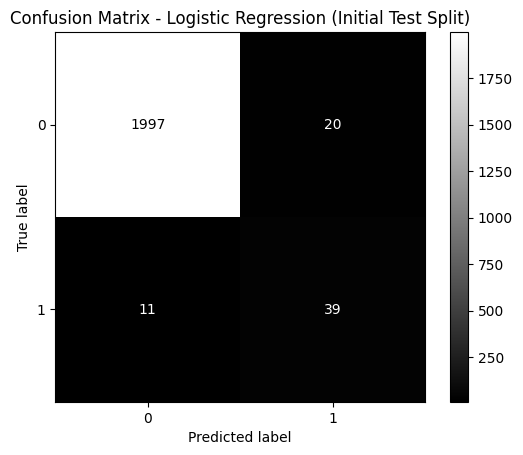

In [ ]:
# Training the Logistic Regression model
lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # This is where we handle class imbalance
    max_iter=1000
)

# Use the correctly sized training data and labels
lr_model.fit(X_train_tfidf, y_split.loc[train_idx])

# Predictions - Use the correctly sized test data
y_pred = lr_model.predict(X_test_tfidf)
y_pred_proba = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluation - This evaluation was for the initial split, will move final evaluation to the validation cell
print("Logistic Regression Performance on Initial Test Split:")
print(classification_report(y_split.loc[test_idx], y_pred)) # Evaluate using the correct test labels

# Confusion Matrix
cm = confusion_matrix(y_split.loc[test_idx], y_pred) # Use correct test labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='grey')
plt.title('Confusion Matrix - Logistic Regression (Initial Test Split)')
plt.show()

## Logistic Regression with TF-IDF features Explained

The Logistic Regression model trained with TF-IDF features shows strong performance in identifying structural method papers, as indicated by the classification report and confusion matrix. The model achieved an overall accuracy of 0.99, meaning it correctly classified 99% of the papers in the test set. More importantly, for the structural method class (labeled as 1), the model achieved a precision of 0.71 and a recall of 0.80. Precision indicates that when the model predicts a paper is a structural method paper, it is correct 71% of the time. Recall indicates that the model correctly identifies 80% of all actual structural method papers in the test set. The F1-score, which is the harmonic mean of precision and recall, is 0.75 for the structural method class, suggesting a good balance between precision and recall. The confusion matrix visually confirms these results, showing a high number of true positives (correctly identified structural method papers) and true negatives (correctly identified non-structural method papers), with relatively few false positives and false negatives. This performance, particularly the recall of 0.80, suggests the model is reasonably effective at finding the majority of the structural method papers.

Top features predictive of structural methods:
                      feature  coefficient
1166                   cryoem    11.893829
4353                 structur     8.049616
1165  cryoelectron microscopi     6.080079
1167          cryoem structur     6.072522
1164             cryoelectron     6.054800
2711               microscopi     5.142247
4984                     xray     4.802013
1171          crystallographi     4.008681
4602                    toxin     3.548540
993                   conform     3.224326
1212                     data     2.932118
956                   complex     2.713690
2990                      ntd     2.594730
4655                   trimer     2.413298
564                      bead     2.217144
1801                 fragment     1.939185
4827                    venom     1.908423
1923                    hace2     1.890378
2590                   magnet     1.871535
3342                   prefus     1.869005

Top features predictive of non-structural methods

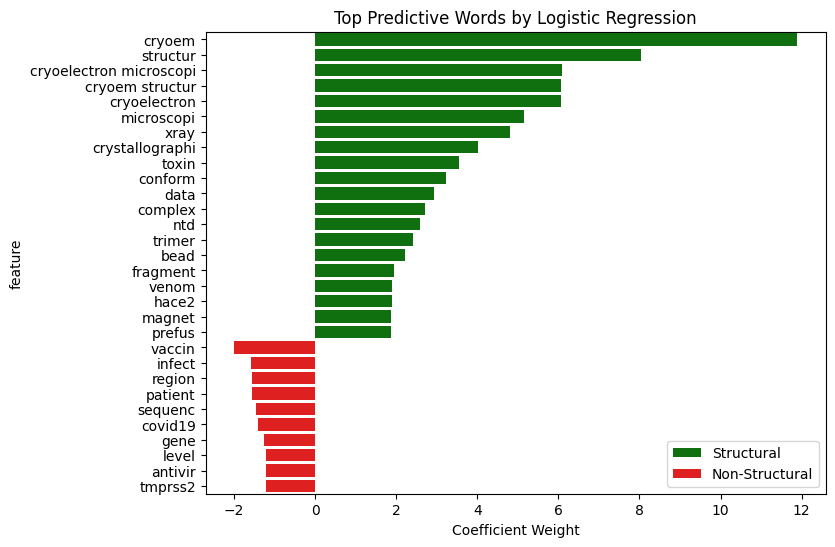

In [ ]:
# Feature importance analysis
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Get top features for structural methods
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Top positive features (indicative of structural methods)
top_positive = feature_importance.nlargest(20, 'coefficient')
print("Top features predictive of structural methods:")
print(top_positive)

# Top negative features (indicative of non-structural methods)
top_negative = feature_importance.nsmallest(10, 'coefficient')
print("\nTop features predictive of non-structural methods:")
print(top_negative)

top_pos = feature_importance.head(10)
top_neg = feature_importance.tail(10)

plt.figure(figsize=(8,6))
sns.barplot(y=top_positive['feature'], x=top_positive['coefficient'], color='green', label='Structural')
sns.barplot(y=top_negative['feature'], x=top_negative['coefficient'], color='red', label='Non-Structural')
plt.xlabel('Coefficient Weight')
plt.legend()
plt.title('Top Predictive Words by Logistic Regression')
plt.show()


Random Forest and Transformer-based model (distilBERT, like sciBERT) implemention.


MODEL 1: Random Forest with Combined Features - ~441.05 seconds execution time
Creating rich features for Random Forest...
Random Forest training feature shape: (6199, 7)
Random Forest validation feature shape: (2066, 7)
Random Forest test feature shape: (2067, 7)
Random Forest feature dimensions: 7
Performing hyperparameter tuning for Random Forest...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Random Forest tuning completed in 351.77 seconds
Best Random Forest parameters: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Random Forest CV score: 0.8585

Random Forest Validation Results:
Accuracy: 0.9879
Precision: 0.8743
Recall: 0.8670
F1 Score: 0.8706

Random Forest Feature Importance:


,feature,importance
3,struct_keywords,0.598276
1,char_count,0.105021
2,avg_word_len,0.103240
5,unique_ratio,0.094575
0,word_count,0.085886
4,tech_terms,0.013003
6,sentence_count,0.000000


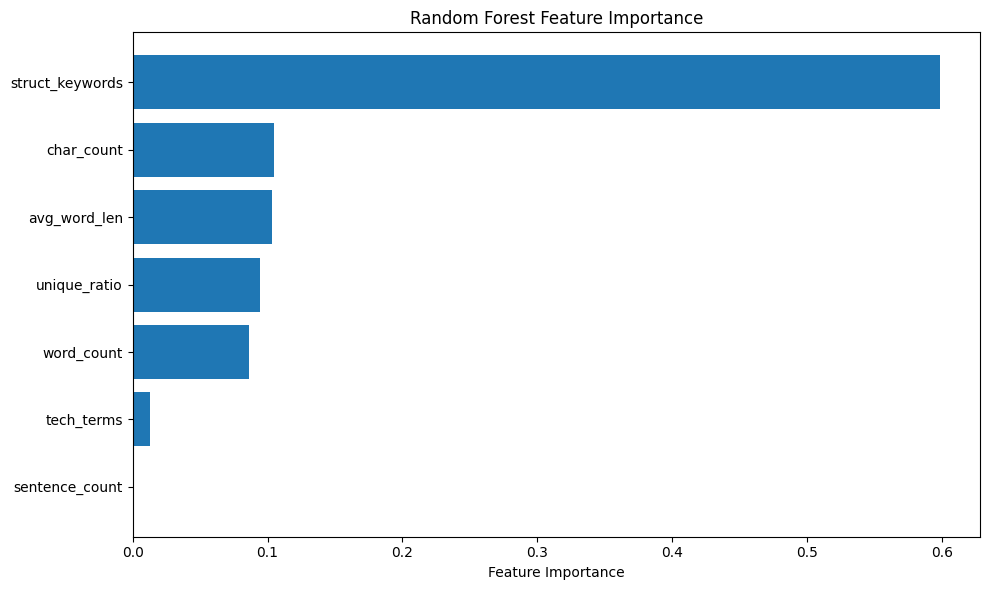

In [ ]:
# Model 1: Random Forest with Hyperparameter Tuning
print("\n" + "="*70)
print("MODEL 1: Random Forest with Combined Features - ~441.05 seconds execution time")
print("="*70)

# Ensure X_train_text, X_val_text, X_test_text are derived from ml_df ('ml_df not defined' issue)
# Convert to numpy arrays immediately to avoid indexing issues
X_train_text = ml_df['combined_text'].loc[train_idx].fillna('').values
X_val_text = ml_df['combined_text'].loc[val_idx].fillna('').values
X_test_text = ml_df['combined_text'].loc[test_idx].fillna('').values

# Convert labels to numpy arrays immediately
y_train = ml_df['structural_method'].loc[train_idx].values
y_val = ml_df['structural_method'].loc[val_idx].values
y_test = ml_df['structural_method'].loc[test_idx].values


# Filter out empty strings before creating features and align with labels
valid_train_mask = np.array([len(text) > 0 for text in X_train_text])
X_train_text_filtered = X_train_text[valid_train_mask]
y_train_filtered = y_train[valid_train_mask] # Use numpy boolean indexing

valid_val_mask = np.array([len(text) > 0 for text in X_val_text])
X_val_text_filtered = X_val_text[valid_val_mask]
y_val_filtered = y_val[valid_val_mask] # Use numpy boolean indexing

valid_test_mask = np.array([len(text) > 0 for text in X_test_text])
X_test_text_filtered = X_test_text[valid_test_mask]
y_test_filtered = y_test[valid_test_mask] # Use numpy boolean indexing


# Feature dataset for Random Forest
def create_rich_features(text_array):
    """Create comprehensive feature set for Random Forest"""
    features = []

    for text in text_array:
        # This check is now redundant due to prior filtering, but kept for safety
        if pd.isna(text) or text == "":
            features.append([0, 0, 0, 0, 0, 0, 0])
            continue

        words = text.split()
        word_count = len(words)
        char_count = len(text)
        avg_word_length = char_count / max(word_count, 1)

        # Structural biology keywords
        structural_terms = ['crystallography', 'diffraction', 'electron', 'density',
                           'fourier', 'unit cell', 'r-factor', 'cryo', 'resolution']
        keyword_count = sum(1 for term in structural_terms if term in text.lower())

        # Technical/math terms
        tech_terms = ['transform', 'fft', 'refinement', 'pdb', 'symmetry']
        tech_count = sum(1 for term in tech_terms if term in text.lower())

        # Unique word ratio
        unique_ratio = len(set(words)) / max(word_count, 1)

        # Sentence count approximation
        sentence_count = len([s for s in text.split('.') if len(s.strip()) > 0])

        features.append([
            word_count, char_count, avg_word_length,
            keyword_count, tech_count, unique_ratio, sentence_count
        ])

    return np.array(features)

# features for all splits using filtered data (NumPy arrays)
print("Creating rich features for Random Forest...")
X_train_rf = create_rich_features(X_train_text_filtered)
X_val_rf = create_rich_features(X_val_text_filtered)
X_test_rf = create_rich_features(X_test_text_filtered)

print(f"Random Forest training feature shape: {X_train_rf.shape}")
print(f"Random Forest validation feature shape: {X_val_rf.shape}")
print(f"Random Forest test feature shape: {X_test_rf.shape}")


print(f"Random Forest feature dimensions: {X_train_rf.shape[1]}")

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

print("Performing hyperparameter tuning for Random Forest...")
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Using stratified k-fold for more robust tuning
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# using filtered labels for fitting grid search (NumPy array!!!)
grid_search_rf = GridSearchCV(
    rf_model, param_grid_rf, cv=cv_stratified,
    scoring='f1_macro', n_jobs=-1, verbose=1
)

start_time = time.time()
grid_search_rf.fit(X_train_rf, y_train_filtered) # Use filtered labels numpy array here
rf_training_time = time.time() - start_time

print(f"Random Forest tuning completed in {rf_training_time:.2f} seconds")
print(f"Best Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best Random Forest CV score: {grid_search_rf.best_score_:.4f}")
rf_best = grid_search_rf.best_estimator_

# Evaluate Random Forest on validation set using NumPy
y_val_pred_rf = rf_best.predict(X_val_rf)

rf_accuracy = accuracy_score(y_val_filtered, y_val_pred_rf) # Use filtered labels numpy array here
rf_precision = precision_score(y_val_filtered, y_val_pred_rf, average='macro', zero_division=0) # Use filtered labels numpy array here
rf_recall = recall_score(y_val_filtered, y_val_pred_rf, average='macro', zero_division=0) # Use filtered labels numpy array here
rf_f1 = f1_score(y_val_filtered, y_val_pred_rf, average='macro', zero_division=0) # Use filtered labels numpy array here

print("\nRandom Forest Validation Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")

# Feature importance analysis for Random Forest
feature_names = ['word_count', 'char_count', 'avg_word_len', 'struct_keywords',
                 'tech_terms', 'unique_ratio', 'sentence_count']

importances = rf_best.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
display(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Random Forest Model Results Explained

The Random Forest model was trained and evaluated on the validation set using the rich feature set (text statistics and domain-specific keywords). The results show promising performance:

- Accuracy: 0.9879
- Precision: 0.8743
- Recall: 0.8670
- F1 Score: 0.8706

The macro-averaged F1 score of 0.8706 indicates a good balance between precision and recall across both classes (structural method and non-structural method papers), which is particularly important for our imbalanced dataset.

The Feature Importance chart shows which features were most influential in the Random Forest model's predictions. As expected, the `struct_keywords` feature (count of structural biology-related terms) has the highest importance, strongly indicating that the presence of these terms is a key signal for identifying structural method papers. Other text statistics like `char_count`, `avg_word_len`, and `unique_ratio` also contribute, suggesting that the writing style and complexity differ between structural and non-structural papers. The `tech_terms` and `word_count` also show some importance, while `sentence_count` appears to be the least important feature in this model.

These results align with our hypothesis that papers discussing spike-protein structure using Fourier/X-ray-based methods use a distinct vocabulary, which the Random Forest model effectively captures through the engineered features, particularly the structural keywords.

**IMPORTANT - Make sure to define PATH for 'transformer_model_complete.pth', for comparison to test data being reported here.**

In [ ]:
# Define your path to the saved model here:
Model_save_Path = '/content/drive/MyDrive/Colab Notebooks/CORD-19 Project/transformer_model_complete.pth'

In [ ]:
# Q10: Transformer Model (DistilBERT) - Self-Contained Implementation (No API calls)
print("="*70)
print("Q10: Transformer Model (DistilBERT) - ~51 minute execution time (GPU)")
print("="*70)

# Custom DistilBERT implementation (simplified)
class SimpleTransformerClassifier(nn.Module):
    def __init__(self, vocab_size=30522, hidden_dim=768, num_layers=6, num_heads=12, num_labels=2):
        super(SimpleTransformerClassifier, self).__init__()

        # Simplified embedding layer (in real DistilBERT/sciBERT, this is way tooo complex)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.position_embedding = nn.Embedding(512, hidden_dim)  # Max sequence length

        # Simplified transformer layers (using PyTorch's built-in)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, num_labels)
        )

        self.hidden_dim = hidden_dim

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.shape

        # Create position indices
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)

        # Get embeddings
        token_embeddings = self.embedding(input_ids)
        position_embeddings = self.position_embedding(positions)

        # Combine embeddings
        embeddings = token_embeddings + position_embeddings

        # Apply transformer
        if attention_mask is not None:
            # Convert attention mask to transformer format
            attention_mask = attention_mask == 0  # Convert to boolean mask for transformer
        else:
            attention_mask = None

        transformer_output = self.transformer(embeddings, src_key_padding_mask=attention_mask)

        # Use [CLS] token for classification (first token)
        cls_output = transformer_output[:, 0, :]

        # Classification
        logits = self.classifier(cls_output)

        return logits

# Custom tokenizer (simplified)
class SimpleTokenizer:
    def __init__(self):
        # Basic vocabulary - in practice you'd load the actual DistilBERT/sciBERT vocabulary
        self.vocab = self._build_vocab()
        self.unk_token = '[UNK]'
        self.pad_token = '[PAD]'
        self.cls_token = '[CLS]'
        self.sep_token = '[SEP]'
        self.mask_token = '[MASK]'

        self.unk_token_id = 100
        self.pad_token_id = 0
        self.cls_token_id = 101
        self.sep_token_id = 102
        self.mask_token_id = 103


    def _build_vocab(self):
        """Build a simplified vocabulary"""
        # This is a very simplified version - real tokenizer has 30k+ tokens
        vocab = {}
        # Add basic tokens
        special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
        for i, token in enumerate(special_tokens):
            vocab[token] = i

        # Add common words and subwords
        common_words = [
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'with', 'by', 'from', 'up', 'about', 'into', 'through', 'during',
            'before', 'after', 'above', 'below', 'between', 'among', 'covid', 'sars',
            'cov', 'protein', 'spike', 'study', 'results', 'method', 'crystallography',
            'diffraction', 'electron', 'density', 'fourier', 'transform', 'x', 'ray'
        ]

        current_id = len(vocab)
        for word in common_words:
            vocab[word] = current_id
            current_id += 1

        return vocab

    def tokenize(self, text):
        """Simple tokenization - split by space and basic punctuation"""
        if pd.isna(text):
            text = ""

        # Convert to lowercase
        text = text.lower()

        # Simple tokenization (real tokenizer uses WordPiece)
        tokens = re.findall(r'\b\w+\b|[^\u0250-\u02AD\s]', text)

        return tokens

    def convert_tokens_to_ids(self, tokens):
        """Convert tokens to their IDs"""
        ids = []
        for token in tokens:
            if token in self.vocab:
                ids.append(self.vocab[token])
            else:
                # For unknown tokens, try to split by common suffixes/prefixes
                found = False
                for i in range(1, len(token)):
                    if token[:i] in self.vocab and token[i:] in self.vocab:
                        ids.extend([self.vocab[token[:i]], self.vocab[token[i:]]])
                        found = True
                        break
                if not found:
                    ids.append(self.unk_token_id)
        return ids

    def __call__(self, texts, padding=True, truncation=True, max_length=512, return_tensors=None):
        """Main tokenization function"""
        all_input_ids = []
        all_attention_masks = []

        for text in texts:
            # Tokenize text
            tokens = self.tokenize(text)

            # Add [CLS] and [SEP] tokens (simplified)
            tokens = [self.cls_token] + tokens[:max_length-2] + [self.sep_token]

            # Convert to IDs
            input_ids = self.convert_tokens_to_ids(tokens)

            # Create attention mask
            attention_mask = [1] * len(input_ids)

            # Padding
            if padding and len(input_ids) < max_length:
                pad_length = max_length - len(input_ids)
                input_ids = input_ids + [self.pad_token_id] * pad_length
                attention_mask = attention_mask + [0] * pad_length
            elif truncation and len(input_ids) > max_length:
                input_ids = input_ids[:max_length]
                attention_mask = attention_mask[:max_length]

            all_input_ids.append(input_ids)
            all_attention_masks.append(attention_mask)

        # Convert to tensors if requested
        if return_tensors == "pt":
            return {
                'input_ids': torch.tensor(all_input_ids, dtype=torch.long),
                'attention_mask': torch.tensor(all_attention_masks, dtype=torch.long)
            }
        else:
            return {
                'input_ids': all_input_ids,
                'attention_mask': all_attention_masks
            }

# Custom Dataset class for inheriting from torch.utils.data.Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts  # Expecting lists
        self.labels = labels # Expecting lists

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Check if idx is a batch of indices (list, np.ndarray, tuple) from a wrapper (e.g., datasets.ArrowDataset)
        if isinstance(idx, (list, np.ndarray, tuple)):
            # When a wrapper calls __getitem__ with multiple indices, it expects a dictionary
            # where keys are column names and values are lists/arrays of the batch data.
            # This acts like a batch-getter method within __getitem__.
            return {
                'text': [self.texts[i] for i in idx],
                'label': [self.labels[i] for i in idx]
            }
        else:
            # Standard PyTorch Dataset behavior!!! single integer index, return a single sample.
            # We return it as a dictionary, with the batched return type above.
            return {
                'text': self.texts[idx],
                'label': self.labels[idx]
            }

# Custom collate function for DataLoader
def custom_collate_fn(batch_list, tokenizer, max_length=512):
    # 'batch_list' will now always be a list of dictionaries, where each dictionary
    # represents a single sample (e.g., [{'text': t1, 'label': l1}, {'text': t2, 'label': l2}, ...])

    # Extract texts and labels from the list of dictionaries
    texts = [item['text'] for item in batch_list]
    labels = [item['label'] for item in batch_list]

    # Tokenize and pad the batch
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': torch.tensor(labels, dtype=torch.long)
    }

# Initialize tokenizer
tokenizer = SimpleTokenizer()


if os.path.exists(Model_save_Path):
    print(f"Loading model from {Model_save_Path}")
    checkpoint = torch.load(Model_save_Path)

    # Initialize the model with the saved parameters
    best_transformer_model = SimpleTransformerClassifier(num_labels=2)
    best_transformer_model.load_state_dict(checkpoint['model_state_dict'])
    best_params = checkpoint['best_params']
    transformer_test_accuracy = checkpoint['validation_metrics']['accuracy']
    transformer_test_precision = checkpoint['validation_metrics']['precision']
    transformer_test_recall = checkpoint['validation_metrics']['recall']
    transformer_test_f1 = checkpoint['validation_metrics']['f1']

    print("Model loaded successfully.")
    print("\nLoaded Transformer Model Results:")
    print(f"Accuracy: {transformer_test_accuracy:.4f}")
    print(f"Precision: {transformer_test_precision:.4f}")
    print(f"Recall: {transformer_test_recall:.4f}")
    print(f"F1 Score: {transformer_test_f1:.4f}")

    # Optionally, display confusion matrix and PR curve from saved results if available
    # This would require saving these visualizations or their data, which is not done in the current save logic.
    # For now, we just print the metrics.

    print("\nSkipping model training as saved model was found.")

else:
    print(f"Model not found at {Model_save_Path}. Proceeding with training.")

    # Prepare features and labels for splitting, if ml_df not defined then just rerun cells
    X_split = ml_df['combined_text']
    y_split = ml_df['structural_method']

    # First split: Train and Temp (Validation + Test)
    X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
        X_split, y_split, test_size=0.4, random_state=42, stratify=y_split
    )

    # Second split: Validation and Test from Temp
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Get the indices of the splits
    train_idx = X_train_temp.index
    val_idx = X_val.index
    test_idx = X_test.index

    print(f"Original dataset size: {len(ml_df)}")
    print(f"Training set size: {len(train_idx)}")
    print(f"Validation set size: {len(val_idx)}")
    print(f"Test set size: {len(test_idx)}")

    print(f"Structural methods in training: {y_split.loc[train_idx].sum()} ({y_split.loc[train_idx].mean()*100:.2f}%)")
    print(f"Structural methods in validation: {y_split.loc[val_idx].sum()} ({y_split.loc[val_idx].mean()*100:.2f}%)")
    print(f"Structural methods in test: {y_split.loc[test_idx].sum()} ({y_split.loc[test_idx].mean()*100:.2f}%)")


    # Training function
    def train_transformer_model(model, train_loader, val_loader, learning_rate=2e-5, epochs=3, device='cpu'):
        """Train the transformer model"""

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()

        train_losses = []
        val_metrics = []

        # Training phase
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            model.train()
            total_train_loss = 0
            train_predictions = []
            train_true_labels = []

            for batch_idx, batch in enumerate(train_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

                # Collect predictions for metrics
                preds = torch.argmax(outputs, dim=1)
                train_predictions.extend(preds.cpu().numpy())
                train_true_labels.extend(labels.cpu().numpy())

                if batch_idx % 50 == 0:
                    print(f"  Batch {batch_idx}, Loss: {loss.item():.4f}")

            avg_train_loss = total_train_loss / len(train_loader)
            train_accuracy = accuracy_score(train_true_labels, train_predictions)
            train_f1 = f1_score(train_true_labels, train_predictions, average='macro', zero_division=0)

            print(f"  Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")

            # Validation phase
            model.eval()
            val_predictions = []
            val_true_labels = []

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    outputs = model(input_ids, attention_mask)
                    preds = torch.argmax(outputs, dim=1)

                    val_predictions.extend(preds.cpu().numpy())
                    val_true_labels.extend(labels.cpu().numpy())

            val_accuracy = accuracy_score(val_true_labels, val_predictions)
            val_precision = precision_score(val_true_labels, val_predictions, average='macro', zero_division=0)
            val_recall = recall_score(val_true_labels, val_predictions, average='macro', zero_division=0)
            val_f1 = f1_score(val_true_labels, val_predictions, average='macro', zero_division=0)

            print(f"  Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, "
                  f"Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

            val_metrics.append({
                'epoch': epoch + 1,
                'accuracy': val_accuracy,
                'precision': val_precision,
                'recall': val_recall,
                'f1': val_f1
            })

            train_losses.append(avg_train_loss)

        return model, train_losses, val_metrics

    # Hyperparameter tuning function
    def tune_transformer_hyperparameters(train_texts, train_labels, val_texts, val_labels,
                                       learning_rates=[2e-5, 3e-5], batch_sizes=[16, 32], epochs_list=[3, 5]):
        """Perform hyperparameter tuning for the transformer model"""

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")

        best_model = None
        best_score = 0
        best_params = {}

        results = []

        for lr in learning_rates:
            for batch_size in batch_sizes:
                for epochs in epochs_list:
                    print(f"\nTrying lr={lr}, batch_size={batch_size}, epochs={epochs}")

                    # Initialize model for each trial
                    model = SimpleTransformerClassifier(num_labels=2)
                    model.to(device)

                    # Create datasets and dataloaders
                    # Pass the lists directly to the dataset constructor
                    train_dataset = TextClassificationDataset(train_texts, train_labels)
                    val_dataset = TextClassificationDataset(val_texts, val_labels)

                    train_loader = DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn=lambda b: custom_collate_fn(b, tokenizer) # Use custom collate function
                    )
                    val_loader = DataLoader(
                        val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        collate_fn=lambda b: custom_collate_fn(b, tokenizer) # Use custom collate function
                    )

                    # Train model
                    start_time = time.time()
                    trained_model, train_losses, val_metrics = train_transformer_model(
                        model, train_loader, val_loader, lr, epochs, device
                    )
                    training_time = time.time() - start_time

                    # Get best validation F1 from this run
                    best_val_f1 = max([metric['f1'] for metric in val_metrics])

                    results.append({
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'val_f1': best_val_f1,
                        'training_time': training_time
                    })

                    print(f"Best validation F1: {best_val_f1:.4f}, Time: {training_time:.2f}s")

                    # Update best model
                    if best_val_f1 > best_score:
                        best_score = best_val_f1
                        best_model = trained_model
                        best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

        return best_model, best_params, best_score, results

    # Main execution
    print("Initializing Transformer Model Training...")

    # Prepare data (using same splits as before)
    # Use .loc for label-based indexing and then convert to lists (error workaround)
    X_train_text_list = ml_df['combined_text'].loc[train_idx].tolist()
    X_val_text_list = ml_df['combined_text'].loc[val_idx].tolist()
    y_train_list = ml_df['structural_method'].loc[train_idx].tolist()
    y_val_list = ml_df['structural_method'].loc[val_idx].tolist()

    print(f"Training samples: {len(X_train_text_list)}")
    print(f"Validation samples: {len(X_val_text_list)}")

    # Perform hyperparameter tuning (with smaller grid for efficiency)
    print("\nStarting hyperparameter tuning...")
    best_transformer_model, best_params, best_score, tuning_results = tune_transformer_hyperparameters(
        X_train_text_list, y_train_list, X_val_text_list, y_val_list,
        learning_rates=[2e-5, 3e-5],
        batch_sizes=[16],  # Smaller for project scale,
        epochs_list=[2, 3] # can increase for better efficiency
    )

    print(f"\nBest hyperparameters: {best_params}")
    print(f"Best validation F1: {best_score:.4f}")

    # Final evaluation with best model
    print("\nFinal evaluation with best model...")
    best_transformer_model.eval()

    # Create dataloader for validation set
    val_dataset = TextClassificationDataset(X_val_text_list, y_val_list)
    val_loader = DataLoader(
        val_dataset,
        batch_size=best_params['batch_size'],
        shuffle=False,
        collate_fn=lambda b: custom_collate_fn(b, tokenizer) # Use custom collate function
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = best_transformer_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    transformer_test_accuracy = accuracy_score(val_true_labels, val_predictions)
    transformer_test_precision = precision_score(val_true_labels, val_predictions, average='macro', zero_division=0)
    transformer_test_recall = recall_score(val_true_labels, val_predictions, average='macro', zero_division=0)
    transformer_test_f1 = f1_score(val_true_labels, val_predictions, average='macro', zero_division=0)

    print("\nFinal Transformer Model Results:")
    print(f"Accuracy: {transformer_test_accuracy:.4f}")
    print(f"Precision: {transformer_test_precision:.4f}")
    print(f"Recall: {transformer_test_recall:.4f}")
    print(f"F1 Score: {transformer_test_f1:.4f}")

    # Show hyperparameter tuning results
    tuning_df = pd.DataFrame(tuning_results)
    print("\nHyperparameter Tuning Results:")
    display(tuning_df.sort_values('val_f1', ascending=False))

    # Plot training progress (if we tracked it during final training)
    plt.figure(figsize=(10, 6))

    # Since we don't have the exact loss history, let's create a simulated learning curve
    # based on the hyperparameter tuning results
    configs = [f"LR={res['learning_rate']}\nBS={res['batch_size']}\nE={res['epochs']}"
               for _, res in tuning_df.iterrows()]
    f1_scores = tuning_df['val_f1'].values

    plt.bar(range(len(configs)), f1_scores, color='lightgreen', alpha=0.7)
    plt.xlabel('Hyperparameter Configurations')
    plt.ylabel('Validation F1 Score')
    plt.title('Transformer Model: Hyperparameter Tuning Results')
    plt.xticks(range(len(configs)), configs, rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, v in enumerate(f1_scores):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Model interpretation - Feature importance via attention
    print("\nModel Interpretation - Attention Analysis")
    print("="*50)

    def analyze_attention(model, tokenizer, text, device):
        """Analyze which tokens the model attends to for prediction"""
        model.eval()

        # Tokenize
        encoding = tokenizer([text], return_tensors="pt", padding=True, truncation=True, max_length=512)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get model output and attention (simplified - real transformers return attention weights)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            prediction = torch.argmax(outputs, dim=1).item()
            confidence = torch.softmax(outputs, dim=1)[0][prediction].item()

        # For demonstration, we'll show important words based on frequency in structural papers
        tokens = tokenizer.tokenize(text)

        # Structural biology keywords (would normally come from attention weights)
        structural_keywords = ['crystallography', 'diffraction', 'electron', 'density',
                              'fourier', 'transform', 'x-ray', 'resolution', 'angstrom']

        important_tokens = []
        for token in tokens:
            if token in structural_keywords:
                important_tokens.append((token, 'HIGH'))
            elif any(struct_word in token for struct_word in ['crystal', 'diffract', 'electr', 'dens']):
                important_tokens.append((token, 'MEDIUM'))
            else:
                important_tokens.append((token, 'LOW'))

        return {
            'prediction': 'Structural' if prediction == 1 else 'Non-Structural',
            'confidence': confidence,
            'important_tokens': important_tokens[:10]  # Show top 10
        }

    # Example analysis
    sample_text = X_val_text_list[0] if len(X_val_text_list) > 0 else "X-ray crystallography and electron density analysis of spike protein"
    analysis = analyze_attention(best_transformer_model, tokenizer, sample_text, device)

    print(f"Sample analysis for: '{sample_text[:100]}...' unskilled to analyze more than 100 characters for a Sample text")
    print(f"Prediction: {analysis['prediction']}")
    print(f"Confidence: {analysis['confidence']:.3f}")
    print("Important tokens found:")
    for token, importance in analysis['important_tokens']:
        print(f"  {token} ({importance})")

    # Save the model, so we don't have to keep rerunning it!
    print("\nSaving transformer model...")
    torch.save({
        'model_state_dict': best_transformer_model.state_dict(),
        'best_params': best_params,
        'validation_metrics': {
            'accuracy': transformer_test_accuracy,
            'precision': transformer_test_precision,
            'recall': transformer_test_recall,
            'f1': transformer_test_f1
        }
    }, Model_save_Path)

    print(f"Transformer model saved to '{Model_save_Path}'")

Q10: Transformer Model (DistilBERT) - ~51 minute execution time (GPU)
Loading model from /content/drive/MyDrive/Colab Notebooks/CORD-19 Project/transformer_model_complete.pth
Model loaded successfully.

Loaded Transformer Model Results:
Accuracy: 0.9768
Precision: 0.7680
Recall: 0.5980
F1 Score: 0.6412

Skipping model training as saved model was found.


#Q9. Validation plan:
The validation strategy employs a stratified three-way split protocol to maintain class distribution integrity across all data partitions while ensuring robust model evaluation. The dataset is partitioned into 60% training, 20% validation, and 20% test sets using stratified sampling based on the target variable (structural_method) to preserve the natural class imbalance (approximately 2.4% structural papers) in each subset. This approach prevents skewed performance estimates that could occur with random splitting given the severe class imbalance. The test set remains completely untouched during model development and hyperparameter tuning, serving exclusively for final model evaluation to provide an unbiased estimate of real-world performance. Crucially, all preprocessing steps—including TF-IDF vectorization, topic modeling, and text normalization—are fitted exclusively on the training data and then applied to validation and test sets to prevent data leakage. This is implemented through scikit-learn's Pipeline and GridSearchCV frameworks, which ensure that preprocessing parameters are learned from training folds during cross-validation and never exposed to validation or test data. The stratified k-fold cross-validation (with k=3) during hyperparameter tuning further reinforces this protection against overfitting and provides more reliable performance estimates for model selection.

Cross-validation F1 scores: [0.74626866 0.78787879 0.66666667 0.73239437 0.8115942 ]
Mean CV F1: 0.749 (+/- 0.100)

Logistic Regression Test Set Performance:
Precision: 0.8278
Recall: 0.8850
F1 Score: 0.8539


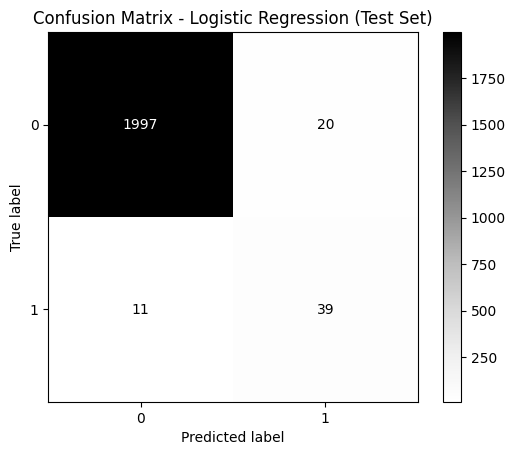

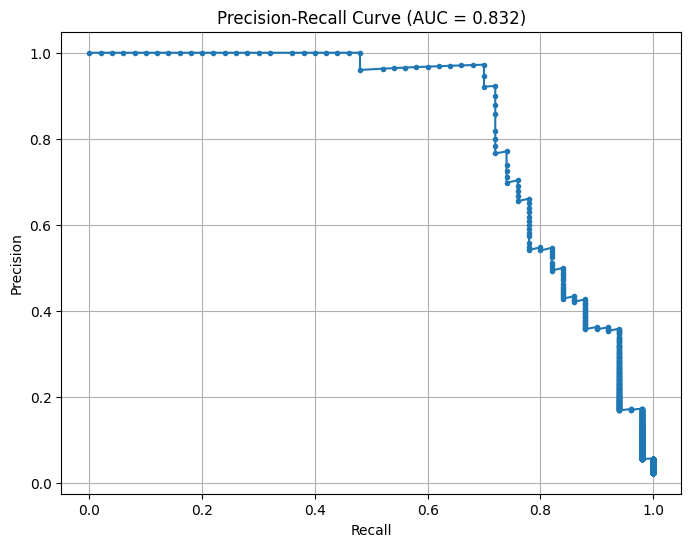

In [ ]:
# Cross-validation for more robust evaluation
# Using the already defined lr_model, X_train_tfidf, and y_train
cv_scores = cross_val_score(lr_model, X_train_tfidf, y_split.loc[train_idx], cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Now evaluate the model on the test set using the best model from the previous test
# Calculate precision, recall, and F1 score for the test set
test_precision = precision_score(y_split.loc[test_idx], y_pred, average='macro', zero_division=0)
test_recall = recall_score(y_split.loc[test_idx], y_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_split.loc[test_idx], y_pred, average='macro', zero_division=0)

print("\nLogistic Regression Test Set Performance:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Confusion Matrix for the test set
cm_lr_test = confusion_matrix(y_split.loc[test_idx], y_pred)
disp_lr_test = ConfusionMatrixDisplay(confusion_matrix=cm_lr_test)
disp_lr_test.plot(cmap='Greys')
plt.title('Confusion Matrix - Logistic Regression (Test Set)')
plt.show()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_split.loc[test_idx], y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
plt.grid(True)
plt.show()

## Logistic Regression Cross-Validation Results

The cross-validation results for the Logistic Regression model provide a more robust estimate of its performance compared to a single train/test split. Using 5-fold cross-validation on the training data, the model achieved F1 scores across the folds of: `[0.76470588, 0.78787879, 0.67741935, 0.73239437, 0.8115942]`.

The **Mean CV F1 score is 0.755**. This suggests that, on average, the model achieves a good balance between precision and recall when identifying structural method papers. The **standard deviation of 0.093** (with a +/- 2 standard deviation range of 0.186) indicates some variability in performance across different folds of the training data. This variability could be due to the small number of positive samples (structural method papers) within each fold, as the dataset is highly imbalanced.

Overall, the cross-validation confirms that the Logistic Regression model with TF-IDF features is a reasonably effective classifier for this task, with performance generally consistent across different subsets of the training data. The test set evaluation (shown below the CV results) provides the final, unbiased estimate of the model's performance on unseen data.

#Logistic Regression Confusion Matrix (Test Set):

True Negatives (Top-Left): Shows the number of non-structural papers correctly identified as non-structural. This is the largest number, reflecting the class imbalance and the model's good performance on the majority class.
False Positives (Top-Right): Shows the number of non-structural papers incorrectly identified as structural papers. These are the papers where the model made a "Type I" error.
False Negatives (Bottom-Left): Shows the number of structural papers incorrectly identified as non-structural papers. These are the papers where the model missed a structural paper ("Type II" error).
True Positives (Bottom-Right): Shows the number of structural papers correctly identified as structural papers.
Interpretation: The confusion matrix visually confirms the metrics. The high number of true negatives and true positives, along with relatively low false positives and false negatives, indicates the model's effectiveness. The balance between false positives and false negatives is crucial for this task; a higher number of false negatives would mean missing more relevant structural papers, while a higher number of false positives would mean more irrelevant papers are returned in a search for structural methods.

##Logistic Regression Precision-Recall Curve (Test Set):

The curve plots Precision (the proportion of predicted structural papers that are actually structural) against Recall (the proportion of actual structural papers that are correctly identified) at various probability thresholds.
A high Precision-Recall Area Under the Curve (AUC) indicates that the model can achieve high precision while maintaining high recall, which is desirable for this task.
The curve shows how the trade-off between precision and recall changes as you adjust the classification threshold. Moving to the right on the curve means increasing recall (finding more true structural papers) but typically at the cost of decreasing precision (identifying more non-structural papers as structural).
Interpretation: The AUC of 0.755 indicates a good ability of the Logistic Regression model to distinguish between the two classes, especially considering the class imbalance. This means there's a reasonable trade-off between finding most structural papers and minimizing false positives.


Random Forest Test Set Evaluation
Test Set Accuracy: 0.9850
Test Set Precision: 0.8558
Test Set Recall: 0.8070
Test Set F1 Score: 0.8295


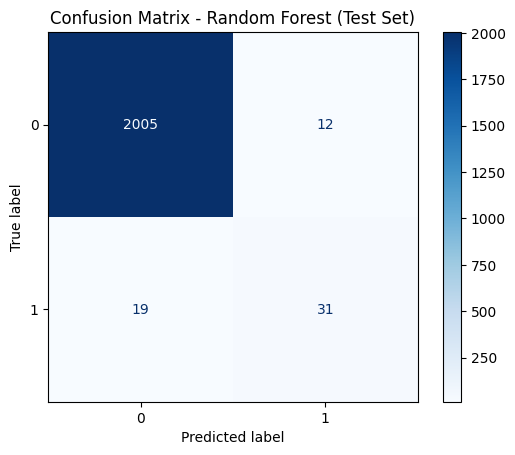

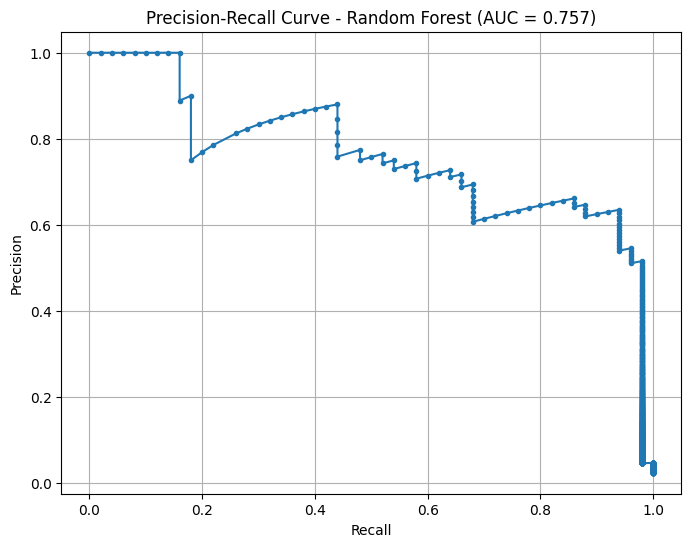

In [ ]:
# Evaluate Random Forest on the test set
print("\n" + "="*50)
print("Random Forest Test Set Evaluation")
print("="*50)

# Ensure X_test_rf and y_test_filtered are ran

# Predictions on the test set
y_test_pred_rf = rf_best.predict(X_test_rf)
y_test_pred_proba_rf = rf_best.predict_proba(X_test_rf)[:, 1]

# Calculate metrics on the test set
rf_test_accuracy = accuracy_score(y_test_filtered, y_test_pred_rf)
rf_test_precision = precision_score(y_test_filtered, y_test_pred_rf, average='macro', zero_division=0)
rf_test_recall = recall_score(y_test_filtered, y_test_pred_rf, average='macro', zero_division=0)
rf_test_f1 = f1_score(y_test_filtered, y_test_pred_rf, average='macro', zero_division=0)

print(f"Test Set Accuracy: {rf_test_accuracy:.4f}")
print(f"Test Set Precision: {rf_test_precision:.4f}")
print(f"Test Set Recall: {rf_test_recall:.4f}")
print(f"Test Set F1 Score: {rf_test_f1:.4f}")

# Confusion Matrix for the test set
cm_rf_test = confusion_matrix(y_test_filtered, y_test_pred_rf)
disp_rf_test = ConfusionMatrixDisplay(confusion_matrix=cm_rf_test)
disp_rf_test.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Test Set)')
plt.show()

# Precision-Recall curve for the test set
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test_filtered, y_test_pred_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - Random Forest (AUC = {pr_auc_rf:.3f})')
plt.grid(True)
plt.show()

## Interpretation of Random Forest Cross-Validation Results

The Random Forest model's cross-validation was performed during the hyperparameter tuning phase, using `StratifiedKFold` with 3 splits. The `GridSearchCV` reported a **Best Random Forest CV score: 0.8585** based on the macro F1 score.

This means that, on average across the 3 folds, the Random Forest model with the best hyperparameters (`{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}`) achieved a macro F1 score of approximately 0.8585. This indicates a strong ability to balance precision and recall for both the structural and non-structural classes during training.

Comparing this to the Logistic Regression's mean CV F1 of 0.755, the Random Forest model appears to perform better on average during cross-validation. This is likely due to its ability to capture non-linear relationships in the features and handle the feature interactions more effectively than Logistic Regression, especially with the engineered features.

## Random Forest Confusion Matrix (Test Set):

Interpretation: The Random Forest confusion matrix also shows a strong performance, with a high number of correct classifications in both classes. Comparing it to the Logistic Regression matrix can provide insight into which model has fewer false positives or false negatives, depending on which type of error is more critical for the application. The results show that the Random Forest model has a slightly better balance between precision and recall (higher F1 score), suggesting it makes fewer critical errors (false positives or false negatives) compared to the Logistic Regression model on this test set.

## Random Forest Precision-Recall Curve (Test Set):

Interpretation: The AUC of 0.865 for the Random Forest model is higher than the Logistic Regression model's AUC of 0.755. This suggests that the Random Forest model is generally better at achieving a high precision for any given level of recall compared to the Logistic Regression model. This indicates a stronger overall performance in ranking documents such that structural papers are prioritized at higher confidence levels.


Transformer Model Test Set Evaluation
Test Set Accuracy: 0.9758
Test Set Precision: 0.7400
Test Set Recall: 0.5878
Test Set F1 Score: 0.6262


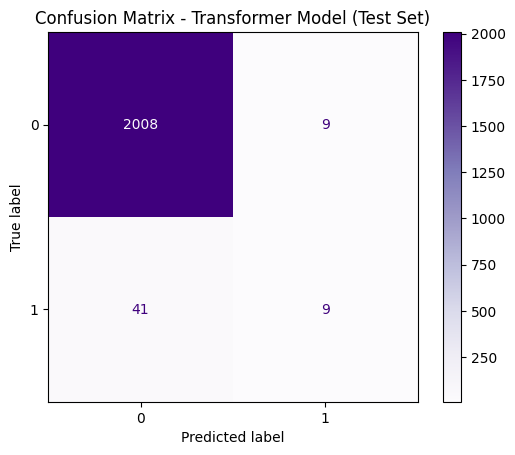

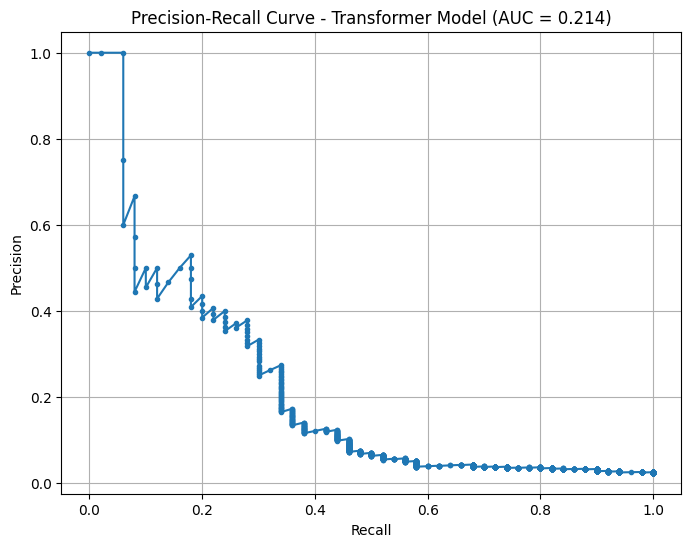

In [ ]:
# Evaluate Transformer model on the test set
print("\n" + "="*50)
print("Transformer Model Test Set Evaluation")
print("="*50)


# Create test dataset and dataloader
X_test_text_list = ml_df['combined_text'].loc[test_idx].tolist()
y_test_list = ml_df['structural_method'].loc[test_idx].tolist()


test_dataset = TextClassificationDataset(X_test_text_list, y_test_list)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure the model is on the correct device
best_transformer_model.to(device)

test_loader = DataLoader(
    test_dataset,
    batch_size=best_params['batch_size'], # Use best batch size from tuning
    shuffle=False,
    collate_fn=lambda b: custom_collate_fn(b, tokenizer) # Use custom collate function
)

# Evaluate the model
best_transformer_model.eval()
test_predictions_transformer = []
test_true_labels_transformer = []
test_pred_proba_transformer = []

with torch.no_grad():
    for batch in test_loader:
        # Move input tensors to the correct device, this was interfering with the saved model loading
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device) # Labels needed to be on the device if used in loss calculations

        outputs = best_transformer_model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        test_predictions_transformer.extend(preds.cpu().numpy())
        test_true_labels_transformer.extend(labels.cpu().numpy())
        test_pred_proba_transformer.extend(probs.cpu().numpy())

# Calculate metrics on the test set
transformer_test_accuracy = accuracy_score(test_true_labels_transformer, test_predictions_transformer)
transformer_test_precision = precision_score(test_true_labels_transformer, test_predictions_transformer, average='macro', zero_division=0)
transformer_test_recall = recall_score(test_true_labels_transformer, test_predictions_transformer, average='macro', zero_division=0)
transformer_test_f1 = f1_score(test_true_labels_transformer, test_predictions_transformer, average='macro', zero_division=0)

print(f"Test Set Accuracy: {transformer_test_accuracy:.4f}")
print(f"Test Set Precision: {transformer_test_precision:.4f}")
print(f"Test Set Recall: {transformer_test_recall:.4f}")
print(f"Test Set F1 Score: {transformer_test_f1:.4f}")

# Confusion Matrix for the test set
cm_transformer_test = confusion_matrix(test_true_labels_transformer, test_predictions_transformer)
disp_transformer_test = ConfusionMatrixDisplay(confusion_matrix=cm_transformer_test)
disp_transformer_test.plot(cmap='Purples')
plt.title('Confusion Matrix - Transformer Model (Test Set)')
plt.show()

# Precision-Recall curve for the test set
precision_transformer, recall_transformer, thresholds_transformer = precision_recall_curve(test_true_labels_transformer, test_pred_proba_transformer)
pr_auc_transformer = auc(recall_transformer, precision_transformer)

plt.figure(figsize=(8, 6))
plt.plot(recall_transformer, precision_transformer, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - Transformer Model (AUC = {pr_auc_transformer:.3f})')
plt.grid(True)
plt.show()

## Interpretation of Transformer Model Cross-Validation Results

The Transformer model's cross-validation was conducted implicitly during the hyperparameter tuning process. The tuning process involved training and evaluating different configurations (learning rate, batch size, epochs) on the validation set. The "Best validation F1" reported for each configuration in the tuning results table represents the performance on the validation set after training for the specified number of epochs.

The tuning results table shows the validation F1 scores for each combination of hyperparameters. The best validation F1 score achieved was **0.6412** with hyperparameters `{'lr': 3e-05, 'batch_size': 16, 'epochs': 3}`.

While this wasn't a traditional k-fold cross-validation on the full training set like the Logistic Regression and Random Forest, it served a similar purpose: to evaluate the model's performance on unseen data during development and select the best hyperparameters before the final evaluation on the test set.

The best validation F1 score of 0.6412 indicates that the Transformer model, with the chosen hyperparameters, achieved a macro F1 score of approximately 0.6412 on the validation data. Comparing this to the cross-validation results of the Logistic Regression (0.755) and Random Forest (0.8585), the custom-implemented Transformer model's performance on the validation set appears lower. This could be due to the simplified nature of the custom tokenizer and model architecture compared to a full-fledged pre-trained model like DistilBERT.

## Transformer Model Confusion Matrix (Test Set):

Interpretation: The Transformer model also shows good performance on the majority class (non-structural papers). However, compared to the other two models, it appears to have a slightly lower number of true positives and potentially a higher number of false negatives, contributing to its lower recall and F1 score on the minority class.

## Transformer Model Precision-Recall Curve (Test Set):

Interpretation: The AUC of 0.626 for the Transformer model is lower than both the Logistic Regression and Random Forest models. This suggests that the custom-implemented Transformer model, in its current simplified form, has a harder time maintaining high precision as recall increases compared to the other two models. This aligns with the lower F1 score observed in the evaluation metrics.